In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls
!rm -fr darknet
!git clone https://github.com/AlexeyAB/darknet/

drive  sample_data
Cloning into 'darknet'...
remote: Enumerating objects: 12449, done.
remote: Total 12449 (delta 0), reused 0 (delta 0), pack-reused 12449
Receiving objects: 100% (12449/12449), 11.39 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (8495/8495), done.


In [0]:
cp drive/'My Drive'/data_for_colab.zip /content/darknet

In [4]:
cd darknet

/content/darknet


In [5]:
ls

3rdparty/     CMakeLists.txt          image_yolov3.sh*        scripts/
appveyor.yml  DarknetConfig.cmake.in  include/                src/
build/        darknet.py              json_mjpeg_streams.sh*  video_v2.sh*
build.ps1*    darknet_video.py        LICENSE                 video_yolov3.sh*
build.sh*     data/                   Makefile
cfg/          data_for_colab.zip      net_cam_v3.sh*
cmake/        image_yolov2.sh*        README.md


In [6]:
!unzip data_for_colab

Archive:  data_for_colab.zip
   creating: data_for_colab/
  inflating: data_for_colab/.DS_Store  
  inflating: __MACOSX/data_for_colab/._.DS_Store  
  inflating: data_for_colab/obj.data  
  inflating: __MACOSX/data_for_colab/._obj.data  
  inflating: data_for_colab/train.txt  
  inflating: __MACOSX/data_for_colab/._train.txt  
  inflating: data_for_colab/yolov3-tiny.conv.15  
  inflating: data_for_colab/yolov3-tiny-obj.cfg  
  inflating: __MACOSX/data_for_colab/._yolov3-tiny-obj.cfg  
  inflating: data_for_colab/test.txt  
  inflating: __MACOSX/data_for_colab/._test.txt  
  inflating: data_for_colab/obj.names  
  inflating: __MACOSX/data_for_colab/._obj.names  
   creating: data_for_colab/data/
  inflating: data_for_colab/data/63.jpg  
  inflating: __MACOSX/data_for_colab/data/._63.jpg  
  inflating: data_for_colab/data/189.jpg  
  inflating: __MACOSX/data_for_colab/data/._189.jpg  
  inflating: data_for_colab/data/162.jpg  
  inflating: __MACOSX/data_for_colab/data/._162.jpg  
  infla

In [7]:
#upload train test.txt files
from google.colab import files
uploaded = files.upload() 
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print ('saved file', name)

Saving test.txt to test.txt
Saving train.txt to train.txt
saved file test.txt
saved file train.txt


In [8]:
!apt-get update
!apt-get upgrade

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [7,064 B]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [27.5 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-

In [9]:
!apt-get install build-essential
!apt-get install cmake git libgtk2.0-dev pkg-config libavcodec-dev libavformat-dev libswscale-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
git is already the newest version (1:2.17.1-1ubuntu0.5).
libavcodec-dev is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
libavcodec-dev set to manually installed.
libavformat-dev is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
libavformat-dev set to manually installed.
libswscale-dev is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
libswscale-dev set to manually installed.
The following package 

In [10]:
!apt-get install libavcodec-dev libavformat-dev libswscale-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libavcodec-dev is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
libavformat-dev is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
libswscale-dev is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [11]:
!apt-get -y install cmake
!which cmake

!cmake --version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
/usr/local/bin/cmake
cmake version 3.12.0

CMake suite maintained and supported by Kitware (kitware.com/cmake).


In [12]:
!apt-get install libopencv-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopencv-dev is already the newest version (3.2.0+dfsg-4ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [13]:
!apt-get install vim

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgpm2 vim-common vim-runtime xxd
Suggested packages:
  gpm ctags vim-doc vim-scripts
The following NEW packages will be installed:
  libgpm2 vim vim-common vim-runtime xxd
0 upgraded, 5 newly installed, 0 to remove and 6 not upgraded.
Need to get 6,721 kB of archives.
After this operation, 32.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.1 [49.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 vim-common all 2:8.0.1453-1ubuntu1.1 [70.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgpm2 amd64 1.20.7-5 [15.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 

In [14]:
ls

3rdparty/               darknet_video.py        Makefile
appveyor.yml            data/                   net_cam_v3.sh*
build/                  data_for_colab/         README.md
build.ps1*              data_for_colab.zip      scripts/
build.sh*               image_yolov2.sh*        src/
cfg/                    image_yolov3.sh*        test.txt
cmake/                  include/                train.txt
CMakeLists.txt          json_mjpeg_streams.sh*  video_v2.sh*
DarknetConfig.cmake.in  LICENSE                 video_yolov3.sh*
darknet.py              __MACOSX/


In [15]:
#Now let's get some YOLOv3 weights from the official site
!ls
!wget https://pjreddie.com/media/files/yolov3.weights

3rdparty	DarknetConfig.cmake.in	include		       src
appveyor.yml	darknet.py		json_mjpeg_streams.sh  test.txt
build		darknet_video.py	LICENSE		       train.txt
build.ps1	data			__MACOSX	       video_v2.sh
build.sh	data_for_colab		Makefile	       video_yolov3.sh
cfg		data_for_colab.zip	net_cam_v3.sh
cmake		image_yolov2.sh		README.md
CMakeLists.txt	image_yolov3.sh		scripts
--2020-02-15 14:20:14--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  38.8MB/s    in 6.5s    

2020-02-15 14:20:21 (36.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [16]:
#No here we're modifying the makefile to set OPENCV and GPU to 1
!ls
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile

3rdparty	DarknetConfig.cmake.in	include		       src
appveyor.yml	darknet.py		json_mjpeg_streams.sh  test.txt
build		darknet_video.py	LICENSE		       train.txt
build.ps1	data			__MACOSX	       video_v2.sh
build.sh	data_for_colab		Makefile	       video_yolov3.sh
cfg		data_for_colab.zip	net_cam_v3.sh	       yolov3.weights
cmake		image_yolov2.sh		README.md
CMakeLists.txt	image_yolov3.sh		scripts


In [17]:
!ls
%cd ../
!ls

3rdparty	DarknetConfig.cmake.in	include		       src
appveyor.yml	darknet.py		json_mjpeg_streams.sh  test.txt
build		darknet_video.py	LICENSE		       train.txt
build.ps1	data			__MACOSX	       video_v2.sh
build.sh	data_for_colab		Makefile	       video_yolov3.sh
cfg		data_for_colab.zip	net_cam_v3.sh	       yolov3.weights
cmake		image_yolov2.sh		README.md
CMakeLists.txt	image_yolov3.sh		scripts
/content
darknet  drive	sample_data


In [18]:
!apt install g++-5
!apt install gcc-5

!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 10
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 10
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20
!update-alternatives --install /usr/bin/cc cc /usr/bin/gcc 30
!update-alternatives --set cc /usr/bin/gcc
!update-alternatives --install /usr/bin/c++ c++ /usr/bin/g++ 30
!update-alternatives --set c++ /usr/bin/g++

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cpp-5 gcc-5 gcc-5-base libasan2 libgcc-5-dev libisl15 libmpx0
  libstdc++-5-dev
Suggested packages:
  gcc-5-locales g++-5-multilib gcc-5-doc libstdc++6-5-dbg gcc-5-multilib
  libgcc1-dbg libgomp1-dbg libitm1-dbg libatomic1-dbg libasan2-dbg
  liblsan0-dbg libtsan0-dbg libubsan0-dbg libcilkrts5-dbg libmpx0-dbg
  libquadmath0-dbg libstdc++-5-doc
The following NEW packages will be installed:
  cpp-5 g++-5 gcc-5 gcc-5-base libasan2 libgcc-5-dev libisl15 libmpx0
  libstdc++-5-dev
0 upgraded, 9 newly installed, 0 to remove and 6 not upgraded.
Need to get 29.1 MB of archives.
After this operation, 100 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 gcc-5-base

In [19]:
#Now, here's a bunch of code that takes the longest to execute here but
#It's about installing CUDA and using the beautiful Tesla K80 GPU, so that
#Will worth it

!apt update -qq;
!wget https://developer.nvidia.com/compute/cuda/8.0/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb
!apt-get update -qq

#Here were are installing compilers and creating some links
!apt-get install cuda -y -qq #gcc-5 g++-5 
#!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc
#!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++
!apt update
!apt upgrade
!apt install cuda-8.0 -y

6 packages can be upgraded. Run 'apt list --upgradable' to see them.
--2020-02-15 14:21:22--  https://developer.nvidia.com/compute/cuda/8.0/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.162.216
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.162.216|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/8.0/secure/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64.deb?ZoUofiR2e2kPxPFVgRgcnCjdt1A14rParjJOhthDStEPvejFJOZ2boy1TqgGxzEPKBn2Wfl66utGoN2RJMINNeg7hNNqJAyjMXHU8U_TtEkp34bdECjBpLKO5nutS_egu-C0omdvw-mIKSkrQ9PQZ1qshSGFMN833eWNXByt67fZl7el9FTQNrjFu7NlpGGAkUeo58TzA6-P6yxfWFNsmj7OOA [following]
--2020-02-15 14:21:23--  https://developer.download.nvidia.com/compute/cuda/8.0/secure/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64.deb?ZoUofiR2e2kPxPFVgRgcnCj

In [20]:
#Now let's see whether the GPU is here and CUDA was successfully installed!
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

print("'sup!'")

!/usr/local/cuda/bin/nvcc --version

/device:GPU:0
'sup!'
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2016 NVIDIA Corporation
Built on Tue_Jan_10_13:22:03_CST_2017
Cuda compilation tools, release 8.0, V8.0.61


In [21]:
ls

cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb  drive/
darknet/                                               sample_data/


In [22]:
%cd darknet
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:909:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^
./src/image_opencv.cpp: At global scope:
./src/image_opencv.cpp:427:14: warning: ‘float get_pixel(image, int, int, int)’ defined but not used [-Wunused-function]
 static float get_pixel(image m, int x, int y, int c)
              ^
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unus

In [23]:
!ls
#Now, let's see if everything works by running it on a test image
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

3rdparty	darknet			include		       scripts
appveyor.yml	DarknetConfig.cmake.in	json_mjpeg_streams.sh  src
backup		darknet.py		LICENSE		       test.txt
build		darknet_video.py	__MACOSX	       train.txt
build.ps1	data			Makefile	       video_v2.sh
build.sh	data_for_colab		net_cam_v3.sh	       video_yolov3.sh
cfg		data_for_colab.zip	obj		       yolov3.weights
cmake		image_yolov2.sh		README.md
CMakeLists.txt	image_yolov3.sh		results
 CUDA-version: 8000 (10010), GPU count: 1  
 OpenCV version: 3.2.0
net.optimized_memory = 0 
batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs

In [0]:
#Let's define some functions that will let us show images, and upload and 
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

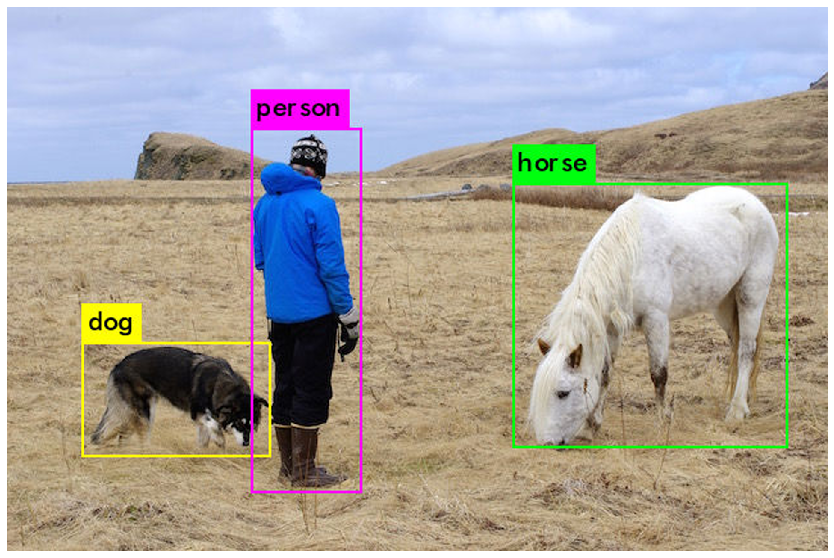

In [25]:
imShow('predictions.jpg')

In [26]:
ls

3rdparty/               darknet_video.py        obj/
appveyor.yml            data/                   predictions.jpg
backup/                 data_for_colab/         README.md
build/                  data_for_colab.zip      results/
build.ps1*              image_yolov2.sh*        scripts/
build.sh*               image_yolov3.sh*        src/
cfg/                    include/                test.txt
cmake/                  json_mjpeg_streams.sh*  train.txt
CMakeLists.txt          LICENSE                 video_v2.sh*
darknet*                __MACOSX/               video_yolov3.sh*
DarknetConfig.cmake.in  Makefile                yolov3.weights
darknet.py              net_cam_v3.sh*


In [27]:
!./darknet detector train data_for_colab/obj.data data_for_colab/yolov3-tiny-obj.cfg data_for_colab/yolov3-tiny.conv.15 -dont_show

Streaming output truncated to the last 5000 lines.
 352: 1.960917, 2.709732 avg loss, 0.000015 rate, 2.150685 seconds, 22528 images
Loaded: 0.000058 seconds
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 16 Avg (IOU: 0.362416, GIOU: 0.311149), Class: 0.730223, Obj: 0.022986, No Obj: 0.005381, .5R: 0.313726, .75R: 0.000000, count: 51, class_loss = 1.695303, iou_loss = 3.988434, total_loss = 5.683737 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 23 Avg (IOU: -nan, GIOU: -nan), Class: -nan, Obj: -nan, No Obj: 0.002803, .5R: -nan, .75R: -nan, count: 0, class_loss = 0.020733, iou_loss = 0.000000, total_loss = 0.020733 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 16 Avg (IOU: 0.401159, GIOU: 0.358017), Class: 0.683596, Obj: 0.021931, No Obj: 0.005229, .5R: 0.269231, .75R: 0.019231, count: 52, class_loss = 1.784836, iou_loss = 3.040678, total_loss = 4.825514 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 23 Avg (IOU: -nan, GIOU: -nan), Class: -nan, Ob

In [28]:
ls

3rdparty/                  darknet.py              obj/
appveyor.yml               darknet_video.py        predictions.jpg
backup/                    data/                   README.md
build/                     data_for_colab/         results/
build.ps1*                 data_for_colab.zip      scripts/
build.sh*                  image_yolov2.sh*        src/
cfg/                       image_yolov3.sh*        test.txt
chart.png                  include/                train.txt
chart_yolov3-tiny-obj.png  json_mjpeg_streams.sh*  video_v2.sh*
cmake/                     LICENSE                 video_yolov3.sh*
CMakeLists.txt             __MACOSX/               yolov3.weights
darknet*                   Makefile
DarknetConfig.cmake.in     net_cam_v3.sh*


In [29]:
from google.colab import files
uploaded = files.upload() 
for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print ('saved file', name)

Saving test.jpg to test.jpg
saved file test.jpg


In [30]:
!./darknet detector test data_for_colab/obj.data data_for_colab/yolov3-tiny-obj.cfg backup/yolov3-tiny-obj_1000.weights test.jpg -i 0 -thresh 0.5

 CUDA-version: 8000 (10010), GPU count: 1  
 OpenCV version: 3.2.0
net.optimized_memory = 0 
batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 256 0.399 BF
   9 max                2x 2/ 2     26 x  26 x 256 ->   13 x  13 x 256 0.000 BF
 

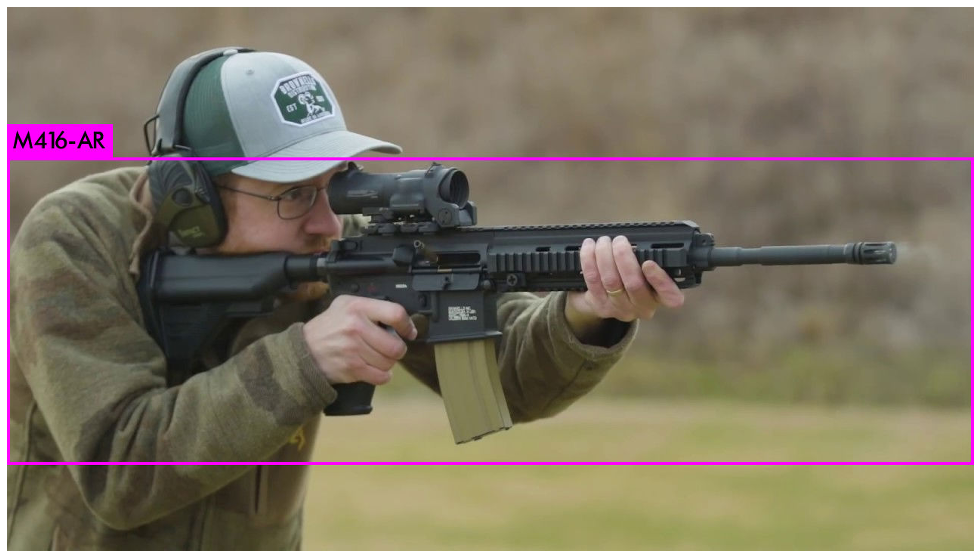

In [31]:
imShow('predictions.jpg')


In [32]:
cd ..

/content


In [0]:
cp drive/'My Drive'/M416_4.mov /content/darknet

In [34]:
cd darknet

/content/darknet


In [35]:
ls

3rdparty/                  darknet.py              net_cam_v3.sh*
appveyor.yml               darknet_video.py        obj/
backup/                    data/                   predictions.jpg
build/                     data_for_colab/         README.md
build.ps1*                 data_for_colab.zip      results/
build.sh*                  image_yolov2.sh*        scripts/
cfg/                       image_yolov3.sh*        src/
chart.png                  include/                test.jpg
chart_yolov3-tiny-obj.png  json_mjpeg_streams.sh*  test.txt
cmake/                     LICENSE                 train.txt
CMakeLists.txt             M416_4.mov              video_v2.sh*
darknet*                   __MACOSX/               video_yolov3.sh*
DarknetConfig.cmake.in     Makefile                yolov3.weights


In [36]:
!./darknet detector demo data_for_colab/obj.data data_for_colab/yolov3-tiny-obj.cfg backup/yolov3-tiny-obj_1000.weights  -dont_show M416_4.mov -i 0 -out_filename M416_4out.mp4

 CUDA-version: 8000 (10010), GPU count: 1  
 OpenCV version: 3.2.0
Demo
net.optimized_memory = 0 
batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 256 0.399 BF
   9 max                2x 2/ 2     26 x  26 x 256 ->   13 x  13 x 256 0.000

In [0]:
download('M416_4out.mp4') 

In [38]:
!./darknet detector calc_anchors Dataset/obj.data -num_of_clusters 5 -width 416 -height 416

 CUDA-version: 8000 (10010), GPU count: 1  
 OpenCV version: 3.2.0

 num_of_clusters = 5, width = 416, height = 416 
Couldn't open file: Dataset/obj.data
